# Identification of N288 as a gate for ligand unbinding from the HIF2𝛼 PAS-B buried cavity

Author: Riccardo Solazzo

E-mail: riccardo.solazzo@phys.chem.ethz.ch

## Introduction 
The purpose of this notebook is to demonstrate the simulation of the unbinding process of THS-017 from HIF2alpha using the Weighted Ensemble (WE) algorithm in WESTPA 2.0. By executing the provided cells, users can replicate the results outlined in the associated publication (DOI: insert DOI). It covers essential steps for WE simulations, including initializing, submitting jobs on HPC, monitoring configuration space sampling, and computing probability flux to evaluate simulation convergence. The commands presented in the notebook can be also executed directly from a Linux terminal.

## List of contents 
- [Environment](#1-environment)
- [Submit jobs on HPC ](#2-submit-jobs-on-hpc)
- [Monitor the simulation](#3-monitor-the-simulation) 
    - [Log file](#log-file)
    - [WEDAP](#wedap) 
- [Check convergence to Steady State](#4-checking-convergence-to-Steady-State)
- [Accelerate convergence to Steady Staate](#5-accelerate-convergence-to-Steady-State)


## 1. Environment 


First of all, make sure that all the required packages needed for running the simulation are properly installed. 
In this work we employed the AMBER MD engine, in order to reproduce our simulation you will need a compiled version of the software able to run on GPU (this step is beyond the scope of this tutorial, instructions for compiling AMBER on you machine/cluster can be found in the AMBER website and in the AMBER manual). 
In addition, the westpa package must be installed in your environment using pip: 

In [ ]:
# Create a conda environment for WESTPA 2.0
!{'conda create -n westpa-2.0 --yes python=3.9'}

# Activate the environment
!{'conda activate westpa-2.0'}

# Install WESTPA 2.0 through pip
!{'pip install westpa'}

At this point we can set up some environment variable executing the env.sh script, which should be previously edited to match your necessities. 
Now we are ready to initialize the weighted ensemble simulation running the init.sh script. 

In [ ]:
import subprocess

# Execute the env.sh script to set up the environment variables. 
!{'./env.sh'}

# Execute the init.sh script to initialize the weighted ensemble simulation.
!{'./init.sh'}

In [ ]:
!{'cat west.cfg'}

## 2. Submit jobs on HPC

The following command can be used for running the simulation on your local machine:

In [ ]:
!{'./run.sh'}

In order to run the simulation on a cluster (recommended) a slurm script needs to be created. Once you requested the proper amount of computational resources the simulation can be submitted running the following command:

In [ ]:
!{'sbatch runwe2.slurm'}

## 3. Monitor the simulation

#### Log file
The easiest way to check the status of the simulation is to read the log file generated during the simulation. 

In [ ]:
!{'tail -n 50 west.log'}

#### WEDAP
To have an idea of the amount of configuration space explored so far it can be useful to visualize the probability distribution of your data. To do so we will use wedap a library written by Darian Yang. 

In the following cell we will visualize the 2D probability distribution of the single components of the multidimensional progress coordinate, the points are colored according to the negative logarithm of the weights (prior to reweight). 

In [ ]:
# Install WEDAP in your conda environment
!{'pip install wedap'}

Import WEDAP to calculate the 2D probability distributions and visualize the results. 

Evolution: 100%|██████████| 475/475 [00:04<00:00, 102.21it/s]


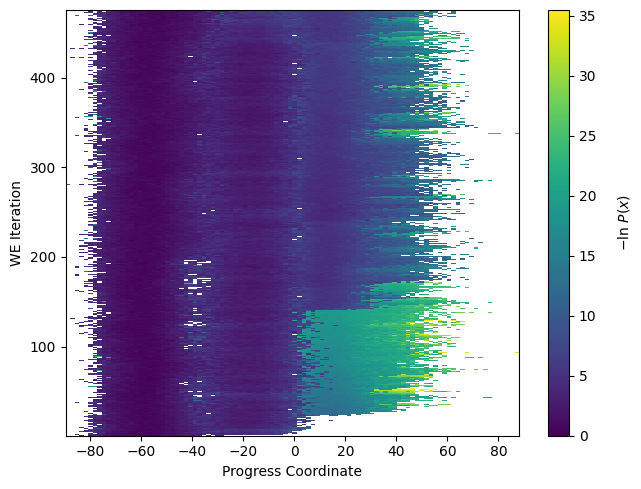

In [2]:
import matplotlib.pyplot as plt
import numpy as np  
import wedap

wedap.H5_Plot(h5="../../../../HIF/HIF2alpha_unbinding/west.h5", data_type="evolution").plot()
plt.xlabel("Progress Coordinate")
plt.ylabel("WE Iteration")
plt.show()

It can be useful to plot the first and the second dimensions of the progress coordinate one against the other. In this way you will get an idea of the correlation between two fundamental events for the unbinding mechanism of THS-017: (1) The opening of the buried pocket and (2) the detachment of the ligand from the protein.

Average 2D: 100%|██████████| 475/475 [00:08<00:00, 54.43it/s]


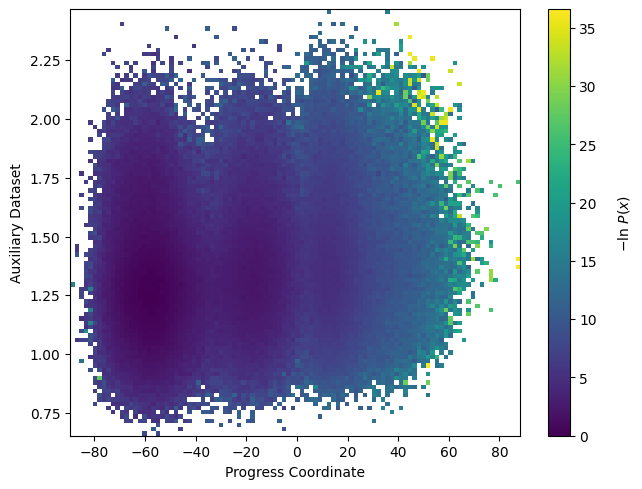

In [4]:
import matplotlib.pyplot as plt
import numpy as np  
import wedap

#wedap.H5_Plot(h5="your_west.h5", data_type="average", Xindex=0, Yindex=1).plot()
wedap.H5_Plot(h5="../../../../HIF/HIF2alpha_unbinding/west.h5", data_type="average", Xindex=0, Yname='IRMSD').plot()
plt.xlabel("Progress Coordinate")
#plt.ylabel("Second Dimension of the progress coordinate")
plt.ylabel("Auxiliary Dataset")
plt.show()

## 4. Checking convergence to Steady State
A WE simulation is converged when it relaxes to a steady state flux. In order to visualize the flux as a function of the molecular time we will need to run the w_ipa command. 
You will need to edit the w_ipa settings in the west.cfg file, then you can run the w_ipa command

In [ ]:
# this line will be commented
!{'cd ../../HIF/HIF2alpha_unbinding/'}
!{'w_ipa -ra'}

The ANALYSIS folder contains the direct.h5 which can be used to visualize the conditional probability fulx. 

Finally we can plot the results. 

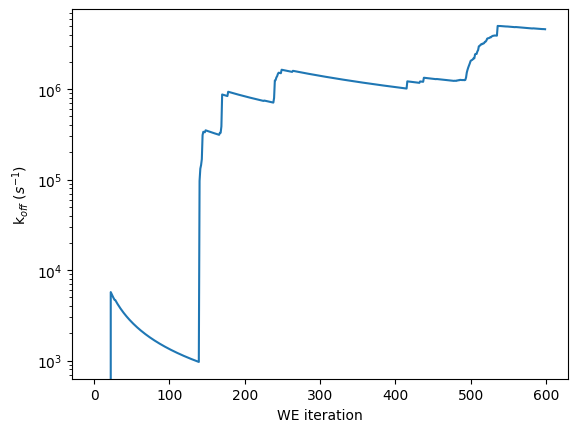

In [12]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py

direct = h5py.File('../../../../HIF/HIF2alpha_unbinding/ANALYSIS/OVERALL/direct.h5', 'r')

flux_AB=direct['conditional_flux_evolution'][:,0,1]['expected']
flux_A=direct['conditional_flux_evolution'][:,0,1]['expected']/1e-10


plt.plot(flux_A)
plt.xlabel('WE iteration')
plt.ylabel('k$_{off}$ ($s^{-1}$)')
plt.yscale('log')

## 5. Accelerate convergence to Steady State
Obtaining steady state distributions using Weighted Ensemble can be very time consuming when simulating a very complex process (e.g. protein-ligand unbinding, protein folding etc.). In these cases it is useful to redistribute the weights using the Weighted Ensemble Steady State plugin. 

1. Open the west.cfg file.
2. Replace the word 'false' with the word 'true' in lines 88 and 89.
3. Increase the value of 'max_total_iterations' (line 60 of west.cfg) by one.
4. Run a weighted ensemble simulation.
5. Replace the word 'true' with the word 'false' in lines 88 and 89.
6. Run 50-100 WE iterations with adjusted weights to relax the system to steady state. 
7. Repeat steps 2 to 6 until the simulation converges.